# Importing Libararies

In [3]:
import os
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from PIL import Image
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
from matplotlib.pyplot import imshow
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Looking into structure of file arrangements

In [11]:
TEST_DIR = '/kaggle/input/broken-eggs/test'
TRAIN_DIR = '/kaggle/input/broken-eggs/train'

In [12]:
print('TRAIN DATA DETAILS')
files = os.listdir(TRAIN_DIR)
print(files)
class_count = len(files)
print(f'There are {class_count} car model classes.')
# Remove Non JPG images
for cls in files:
    cls_path = os.path.join(TRAIN_DIR, cls)
    imgs =  os.listdir(cls_path)
    img = Image.open(os.path.join(cls_path,imgs[0]))
    print(f'Class {cls} contains {len(imgs)} images images of shape {img.size}.')
    for filees in imgs:
        if filees.endswith(('.jpg', '.jpeg')):
            None
        else:
            os.remove(os.path.join(cls_path,filees)) 
    print(f'Class {cls} contains {len(os.listdir(cls_path))} images of shape {img.size}.')

TRAIN DATA DETAILS
['empty', 'good', 'crack']
There are 3 car model classes.
Class empty contains 190 images images of shape (960, 720).
Class empty contains 190 images of shape (960, 720).
Class good contains 190 images images of shape (960, 720).
Class good contains 190 images of shape (960, 720).
Class crack contains 162 images images of shape (960, 720).
Class crack contains 162 images of shape (960, 720).


In [13]:
print('TEST DATA DETAILS')
files = os.listdir(TEST_DIR)
print(files)
class_count = len(files)
print(f'There are {class_count} car model classes.')
# Remove Non JPG images
for cls in files:
    cls_path = os.path.join(TEST_DIR, cls)
    imgs =  os.listdir(cls_path)
    img = Image.open(os.path.join(cls_path,imgs[0]))
    print(f'Class {cls} contains {len(imgs)} images images of shape {img.size}.')
    for filees in imgs:
        if filees.endswith(('.jpg', '.jpeg')):
            None
        else:
            os.remove(os.path.join(cls_path,filees)) 
    print(f'Class {cls} contains {len(os.listdir(cls_path))} images of shape {img.size}.')

TEST DATA DETAILS
['empty', 'good', 'crack']
There are 3 car model classes.
Class empty contains 10 images images of shape (960, 720).
Class empty contains 10 images of shape (960, 720).
Class good contains 10 images images of shape (960, 720).
Class good contains 10 images of shape (960, 720).
Class crack contains 7 images images of shape (960, 720).
Class crack contains 7 images of shape (960, 720).


# Creating the data generator using ImageDataGenerator for the CNN

In [18]:
def train_val_generators():
    """
    Creates the training and validation data generators
    Args:
        TRAINING_DIR (string): directory path containing the training images
        VALIDATION_DIR (string): directory path containing the testing/validation images
    Returns:
        train_generator, validation_generator: tuple containing the generators
    """
    # Instantiate the ImageDataGenerator class, normalize pixel values and set arguments to augment the images 
    train_gen = ImageDataGenerator(rescale=1.0/255.0, 
                                 rotation_range=40,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.1,
                                 zoom_range=0.1,
                                 fill_mode='nearest',
                                 validation_split=0.1)                               
    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_gen.flow_from_directory(directory=TRAIN_DIR,
                                                        batch_size=100, 
                                                        class_mode='categorical',
                                                        shuffle=True,                        
                                                        target_size=(150,150))
    valid_gen = ImageDataGenerator(rescale=1.0/255.0)

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = valid_gen.flow_from_directory(directory=TEST_DIR,
                                                                  batch_size=36, 
                                                                  class_mode='categorical',
                                                                  shuffle = False,
                                                                  target_size=(150, 150))
    return train_generator, validation_generator

In [19]:
train_generator, validation_generator = train_val_generators()

Found 542 images belonging to 3 classes.
Found 27 images belonging to 3 classes.


# Define and compile the transfer learning model

In [20]:
pre_trained_model = tf.keras.applications.vgg16.VGG16(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')
for layer in pre_trained_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [21]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [23]:
# Choose `block5_pool` as the last layer of your base model
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 4, 4, 512)


In [24]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (class_count, activation='softmax')(x)           

# Append the dense network to the base model
model_transfer = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model_transfer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [25]:
model_transfer.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Creating a Callback class

In [26]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the correct function signature for on_epoch_end
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.95): 
            print(logs.get('val_accuracy'))
            print("\nReached 95% validation accuracy so cancelling training!")
callbacks = myCallback()

In [27]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.25,   
    patience=2, 
    min_lr=1e-6,
    verbose=2
)

In [28]:
checkpoint_path = "/kaggle/working/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model

In [29]:
history1 = model_transfer.fit(train_generator,
                    epochs=25,
                    validation_data=validation_generator, 
                    callbacks=[callbacks, reduce_lr, cp_callback]
                   )

Epoch 1/25
6/6 [==============================] - ETA: 0s - loss: 1.4517 - accuracy: 0.5775
Epoch 1: saving model to /kaggle/working/cp.ckpt
6/6 [==============================] - 69s 11s/step - loss: 1.4517 - accuracy: 0.5775 - val_loss: 0.4874 - val_accuracy: 0.8148 - lr: 0.0010
Epoch 2/25
6/6 [==============================] - ETA: 0s - loss: 0.5481 - accuracy: 0.7749
Epoch 2: saving model to /kaggle/working/cp.ckpt
6/6 [==============================] - 67s 11s/step - loss: 0.5481 - accuracy: 0.7749 - val_loss: 0.3543 - val_accuracy: 0.8519 - lr: 0.0010
Epoch 3/25
6/6 [==============================] - ETA: 0s - loss: 0.5653 - accuracy: 0.7934 
Epoch 3: saving model to /kaggle/working/cp.ckpt
6/6 [==============================] - 66s 11s/step - loss: 0.5653 - accuracy: 0.7934 - val_loss: 0.3241 - val_accuracy: 0.8148 - lr: 0.0010
Epoch 4/25
6/6 [==============================] - ETA: 0s - loss: 0.4117 - accuracy: 0.8192 
Epoch 4: saving model to /kaggle/working/cp.ckpt
6/6 [======

In [30]:
print("Accuracy of the transfer_learning model is - " , model_transfer.evaluate(validation_generator)[1]*100 , "%")

1/1 [==============================] - 3s 3s/step - loss: 0.1606 - accuracy: 0.9630
Accuracy of the transfer_learning model is -  96.29629850387573 %


#  Evaluating Accuracy and Loss for the Model

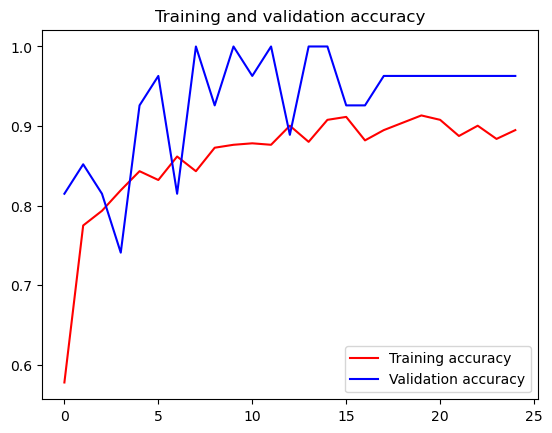

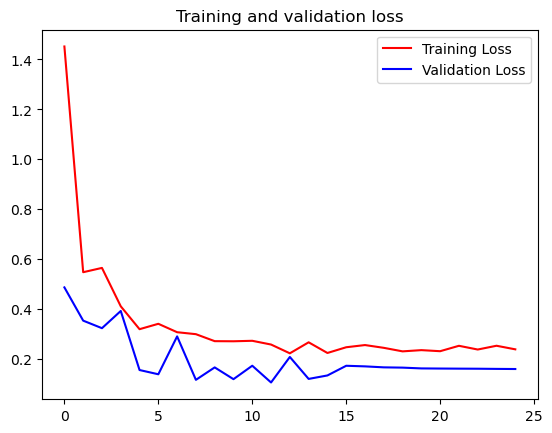

In [31]:
# Plot the chart for accuracy and loss on both training and validation
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
predictions = model_transfer.predict(validation_generator)
predictions=np.argmax(predictions,axis=-1)
print(predictions[:10])
print(validation_generator.labels[:10])

1/1 [==============================] - 4s 4s/step
[0 0 0 0 0 0 0 1 1 1]
[0 0 0 0 0 0 0 1 1 1]


In [33]:
dict_cls = validation_generator.class_indices


#  Evaluating  Precision, Recall, F1-Score and Support for the Model

In [35]:
print(classification_report(validation_generator.labels, predictions, target_names = list(dict_cls.keys())))

              precision    recall  f1-score   support

       crack       0.88      1.00      0.93         7
       empty       1.00      1.00      1.00        10
        good       1.00      0.90      0.95        10

    accuracy                           0.96        27
   macro avg       0.96      0.97      0.96        27
weighted avg       0.97      0.96      0.96        27



# Plotting the Confusion Matrix for the Classification

<AxesSubplot:>

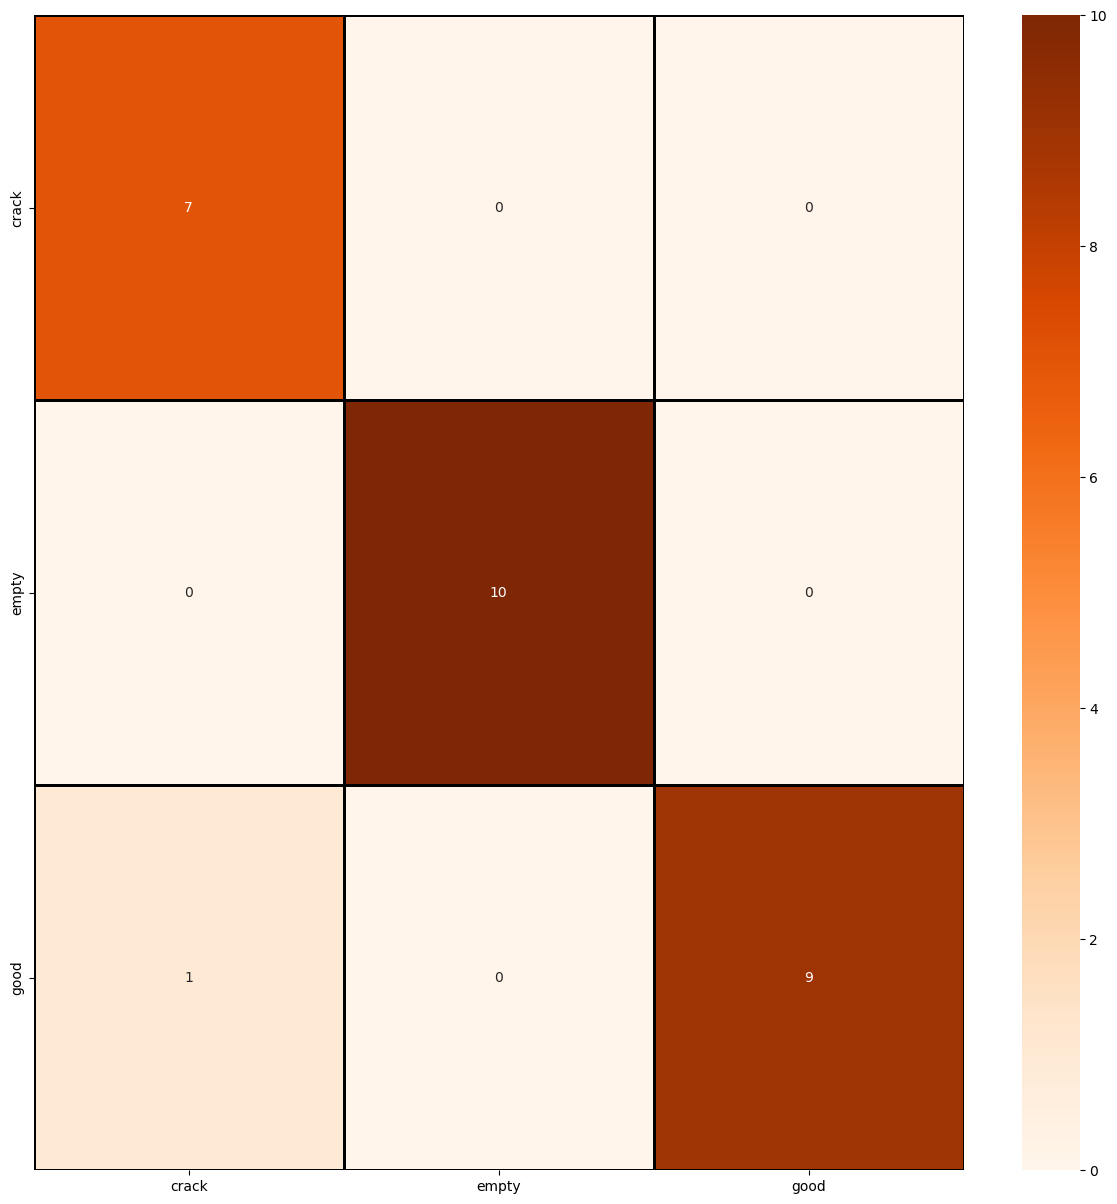

In [36]:
cm = confusion_matrix(validation_generator.labels,predictions)
cm = pd.DataFrame(cm , index = list(dict_cls.keys()) , columns = list(dict_cls.keys()))
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Oranges", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

# Sample Model Prediction

In [43]:
print(validation_generator.class_indices.keys())


dict_keys(['crack', 'empty', 'good'])


In [51]:
def class_name(id):
    key_list = list(dict_cls.keys())
    val_list = list(dict_cls.values())
    position = val_list.index(id)
    return key_list[position]
    

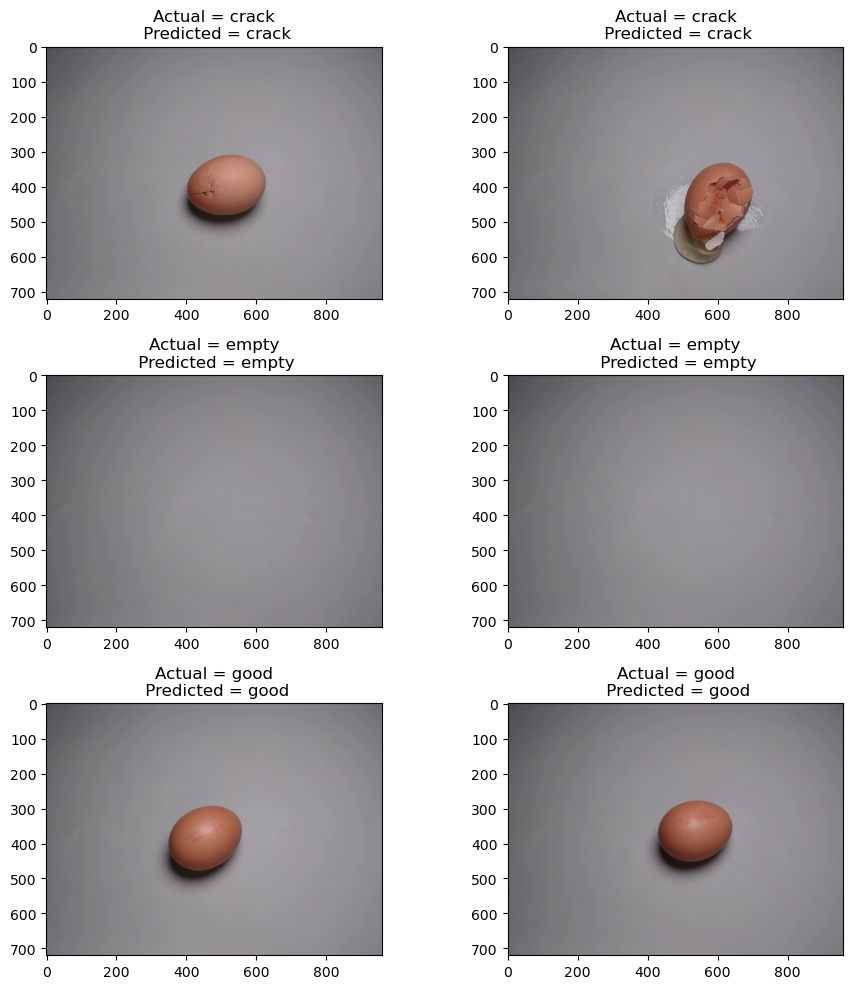

In [61]:
f, ax = plt.subplots(3,2) 
f.set_size_inches(10, 10)
k = 0
for i in range(3):
    for j in range(2):
        true_cls = validation_generator.labels[k]
        true_cls = class_name(true_cls)
        pred_cls = predictions[k]
        pred_cls = class_name(pred_cls)
        ax[i,j].set_title(f'Actual = {true_cls}\n Predicted = {pred_cls}')
        path = TEST_DIR + '/' + validation_generator.filenames[k]
        img=plt.imread(path)
        ax[i,j].imshow(img)
        k += 5
    plt.tight_layout() 